In [1]:
import pandas as pd
import os
import seaborn as sns
from matplotlib import pyplot as plt

In [40]:
python = pd.read_csv("./pc-results/python.csv", skipinitialspace=True)

In [3]:
java = pd.read_csv("./pc-results/java.csv")

In [4]:
def from_jmh(df, lang):
    df = df.copy()
    df = df[["Benchmark", "Score", "Score Error (99.9%)"]] \
          .rename(columns={"Benchmark": "benchmark", "Score": "time", "Score Error (99.9%)": "error"})
    df["benchmark"] = df["benchmark"].str.split('.').str[-1]
    df["language"] = lang
    df.set_index(["benchmark", "language"], inplace=True)
    return df

In [5]:
java_df = from_jmh(java, "java")
java_df

,,time,error
benchmark,language,,
alloc_full_tree,java,1.914627,0.023254
alloc_list,java,68.433480,10.279262
alloc_vector,java,49.593890,0.675363
sum,java,2.734102,0.001240
sum_list,java,6.756459,0.132361
sum_tree,java,1.900161,0.238654
sum_vector,java,5.296833,0.024553


In [8]:
enso = pd.read_csv("./pc-results/enso.csv")

In [26]:
def plot_warm(df):
    plt.figure(figsize=(10, 8))
    sns.lineplot(data=df, x="run_id", y="time", hue="benchmark")
    plt.legend(loc="upper right")
    plt.show()
    for b in df["benchmark"].unique():
        part = df[df["benchmark"] == b]
        plt.title(b)
        sns.lineplot(data=part, x="run_id", y="time")
        plt.show()

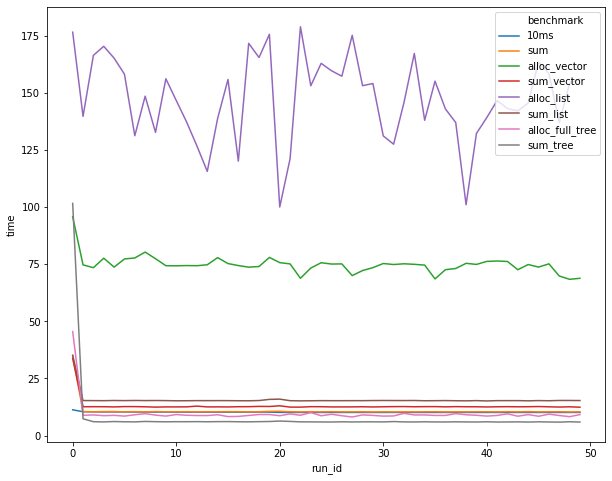

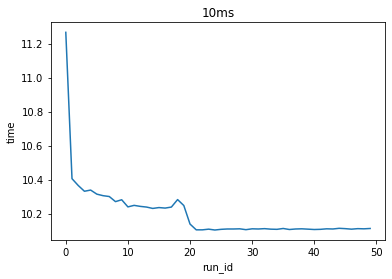

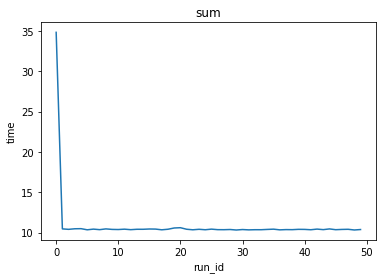

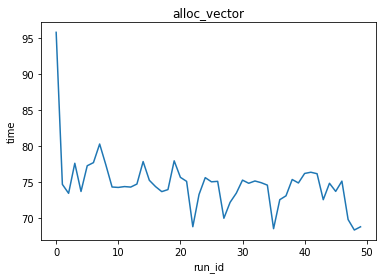

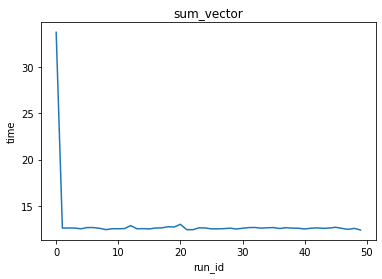

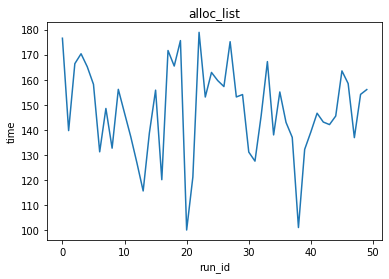

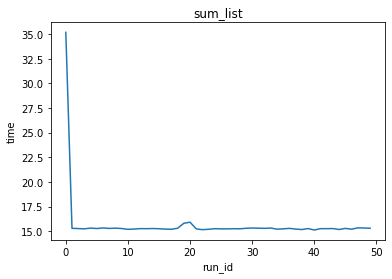

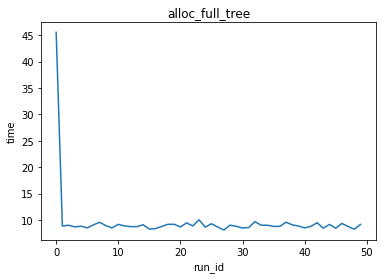

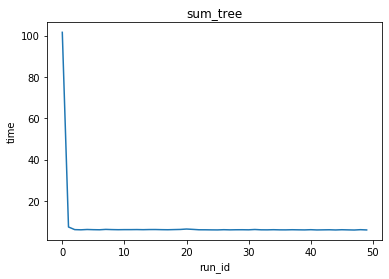

In [27]:
plot_warm(enso)

In [13]:
def aggregate_my(df, lang):
    agg = df.groupby("benchmark")["time"]
    df2 = pd.DataFrame({"low": agg.median() - agg.quantile(0.01), "hi": agg.quantile(0.99) - agg.median()})
    err = df2[["low", "hi"]].max(axis=1)
    df2 = pd.DataFrame({"time": agg.median(), "error": err, "language": lang})
    df2 = df2.reset_index().set_index(["benchmark", "language"])
    return df2

In [28]:
warmup_cutoff = 25

In [29]:
enso_df = aggregate_my(enso[enso["run_id"] > warmup_cutoff], "enso")
enso_df

,,time,error
benchmark,language,,
10ms,enso,10.1090,0.00377
alloc_full_tree,enso,8.8040,0.86678
alloc_list,enso,145.6525,38.52481
alloc_vector,enso,74.7370,6.30922
sum,enso,10.3810,0.08094
sum_list,enso,15.2830,0.13119
sum_tree,enso,5.9605,0.13372
sum_vector,enso,12.5920,0.17690


In [42]:
pydf = aggregate_my(python, "python")

In [43]:
cmp = pd.concat([pydf, java_df, enso_df]).reset_index()
cmp

,benchmark,language,time,error
0,10ms,python,10.101423,0.007468
1,alloc_full_tree,python,290.080971,38.189237
2,alloc_list,python,1902.127238,16.923808
3,alloc_vector,python,692.319687,2.974414
4,sum,python,770.625521,7.949564
5,sum_list,python,137.300487,0.588197
6,sum_tree,python,47.432179,0.317646
7,sum_vector,python,85.979137,0.302445
8,alloc_full_tree,java,1.914627,0.023254
9,alloc_list,java,68.433480,10.279262


   benchmark language       time     error
0       10ms   python  10.101423  0.007468
15      10ms     enso  10.109000  0.003770


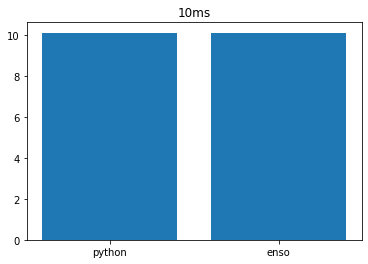

          benchmark language        time      error
1   alloc_full_tree   python  290.080971  38.189237
8   alloc_full_tree     java    1.914627   0.023254
16  alloc_full_tree     enso    8.804000   0.866780


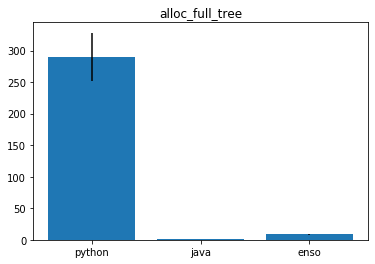

     benchmark language         time      error
2   alloc_list   python  1902.127238  16.923808
9   alloc_list     java    68.433480  10.279262
17  alloc_list     enso   145.652500  38.524810


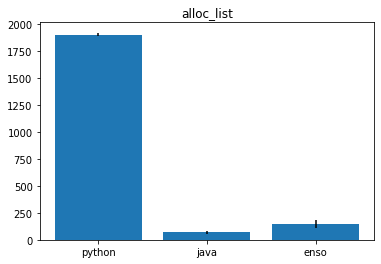

       benchmark language        time     error
3   alloc_vector   python  692.319687  2.974414
10  alloc_vector     java   49.593890  0.675363
18  alloc_vector     enso   74.737000  6.309220


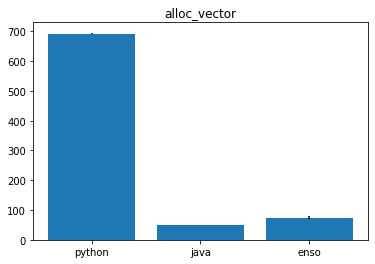

   benchmark language        time     error
4        sum   python  770.625521  7.949564
11       sum     java    2.734102  0.001240
19       sum     enso   10.381000  0.080940


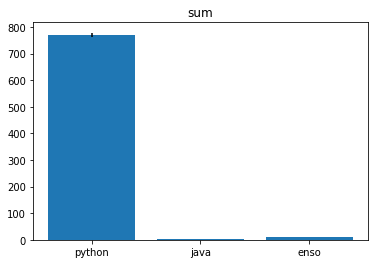

   benchmark language        time     error
5   sum_list   python  137.300487  0.588197
12  sum_list     java    6.756459  0.132361
20  sum_list     enso   15.283000  0.131190


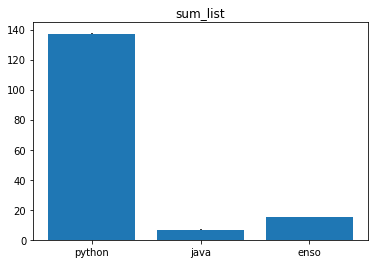

   benchmark language       time     error
6   sum_tree   python  47.432179  0.317646
13  sum_tree     java   1.900161  0.238654
21  sum_tree     enso   5.960500  0.133720


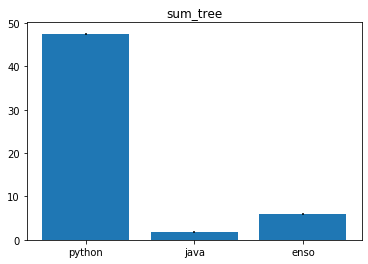

     benchmark language       time     error
7   sum_vector   python  85.979137  0.302445
14  sum_vector     java   5.296833  0.024553
22  sum_vector     enso  12.592000  0.176900


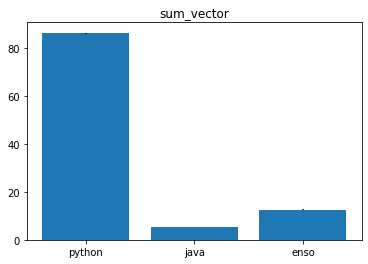

In [44]:
for b in cmp["benchmark"].unique():
    #if b == "100ms":
    #    continue
    part = cmp[cmp["benchmark"] == b]
    print(part)
    plt.bar(x=part["language"], height=part["time"], yerr=part["error"])
    plt.title(b)
    plt.show()

## Information regarding the benchmarks

The basic code is at https://github.com/enso-org/benchmarks/tree/wip/rw/initial-microbenchmarks

For now I have skipped JS and C++ as I don't have a good methodology there. C++ would be doable with some framework, but due to time constraints I couldn't make it. We still compare with Java and C++'s performance on this kind of code should be more-or-less comparable (but of course we should do a good comparison when time allows).

While trying to benchmark Enso, I first was running it in Enso a'la https://github.com/enso-org/enso/tree/main/test/Benchmarks
However as this incurred running different benchmarks in the same JVM and issues with sharing the state of JIT, I tried to repurpose the JMH benchmarks from `runtime` project, that can be found at https://github.com/enso-org/enso/compare/wip/rw/jmh-experiment

So after all I compare Java and Enso using JMH, both are written in a very similar way. They use `avgt` mode which computes average time in milliseconds for operation.

For Python, I run many iterations saving time of each and compute medians (alternatively means) of the timings.

In [46]:
ratios = []
for b in cmp["benchmark"].unique():
    if b == "10ms":
        continue
    part = cmp[cmp["benchmark"] == b]
    ts = part.set_index("language")["time"]
    py = ts.loc["python"] / ts.loc["enso"]
    java = ts.loc["enso"] / ts.loc["java"]
    ratios.append({"benchmark": b, "python/enso": py, "enso/java": java})
ratios = pd.DataFrame.from_records(ratios)
ratios

,benchmark,enso/java,python/enso
0,alloc_full_tree,4.598285,32.948770
1,alloc_list,2.128381,13.059352
2,alloc_vector,1.506980,9.263413
3,sum,3.796859,74.234228
4,sum_list,2.261984,8.983870
5,sum_tree,3.136839,7.957752
6,sum_vector,2.377270,6.828076
